In [ ]:
%reload_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import hopsworks

import os

## DOWNLOAD DATA FROM FEATURE STORE:

In [2]:
from src.training_pipeline import taxi_create_feature_view, taxi_fetch_data_from_feature_store

In [ ]:
feat_view_name = 'backfilled_2020_22'
feat_view_ver = 1
parent_feat_group_name = 'nyc_taxi_demand_timeseries_backfilled_2020_22'
parent_feat_group_ver = 1


taxi_create_feature_view(feat_view_name, feat_view_ver,
                         parent_feat_group_name, parent_feat_group_ver)

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/571540
Connected. Call `.close()` to terminate connection gracefully.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/571540/fs/567363/fv/backfilled_2020_22/version/1


'feature view backfilled_2020_22 created '

In [3]:
feat_view_name, feat_view_ver = "backfilled_2020_22", 1

df_demand = taxi_fetch_data_from_feature_store(feat_view_name, feat_view_ver)
df_demand

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/571540
Connected. Call `.close()` to terminate connection gracefully.


Finished: Reading data from Hopsworks, using Hive (11.88s) 


,date_time,demand
1235,2020-01-01 00:00:00,266
14783,2020-01-01 01:00:00,231
17253,2020-01-01 02:00:00,244
22409,2020-01-01 03:00:00,259
7476,2020-01-01 04:00:00,144
...,...,...
18612,2022-12-31 19:00:00,99
26016,2022-12-31 20:00:00,101
9736,2022-12-31 21:00:00,103
14795,2022-12-31 22:00:00,63


## CREATE ML DATA:

In [4]:
from src.training_pipeline import (taxi_create_ml_dataset, taxi_tr_ts_split,
                                   taxi_train_ml_model, taxi_make_ml_prediction,
                                   taxi_make_forecast)

In [5]:
df_ml = taxi_create_ml_dataset(df_demand, n_lags = 24 * 30)
df_ml

,t720,t719,t718,t717,t716,t715,t714,t713,t712,t711,...,t9,t8,t7,t6,t5,t4,t3,t2,t1,t0
date_time,,,,,,,,,,,,,,,,,,,,,
2020-01-31 00:00:00,266,231,244,259,144,65,33,33,32,44,...,201,186,218,381,312,299,295,274,179,115
2020-01-31 01:00:00,231,244,259,144,65,33,33,32,44,66,...,186,218,381,312,299,295,274,179,115,83
2020-01-31 02:00:00,244,259,144,65,33,33,32,44,66,101,...,218,381,312,299,295,274,179,115,83,43
2020-01-31 03:00:00,259,144,65,33,33,32,44,66,101,114,...,381,312,299,295,274,179,115,83,43,37
2020-01-31 04:00:00,144,65,33,33,32,44,66,101,114,133,...,312,299,295,274,179,115,83,43,37,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,131,146,135,98,129,135,61,44,24,14,...,42,62,61,75,108,70,67,67,65,99
2022-12-31 20:00:00,146,135,98,129,135,61,44,24,14,10,...,62,61,75,108,70,67,67,65,99,101
2022-12-31 21:00:00,135,98,129,135,61,44,24,14,10,14,...,61,75,108,70,67,67,65,99,101,103


## TRAIN & TEST SETS:

In [6]:
df_ml_tr, df_ml_ts = taxi_tr_ts_split(df_ml)
df_ml_tr.shape, df_ml_ts.shape

((21747, 721), (3837, 721))

In [7]:
df_ml_tr.tail().index

DatetimeIndex(['2022-07-24 22:00:00', '2022-07-24 23:00:00',
               '2022-07-25 00:00:00', '2022-07-25 01:00:00',
               '2022-07-25 02:00:00'],
              dtype='datetime64[ns]', name='date_time', freq=None)

In [8]:
df_ml_ts.head().index

DatetimeIndex(['2022-07-25 03:00:00', '2022-07-25 04:00:00',
               '2022-07-25 05:00:00', '2022-07-25 06:00:00',
               '2022-07-25 07:00:00'],
              dtype='datetime64[ns]', name='date_time', freq=None)

## TRAIN REGRESSION MODEL:

In [9]:
import xgboost as xgb

In [10]:
untrained_model = xgb.XGBRegressor(random_state = 8)
trained_model = taxi_train_ml_model(untrained_model, df_ml_tr)
trained_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=8, ...)

In [11]:
y, y_pred = taxi_make_ml_prediction(trained_model, df_ml_ts)
y.shape, y_pred.shape

((3837,), (3837,))

## MODEL PERFORMANCE IN ML MODE:

In [12]:
from src.training_pipeline import taxi_display_mlmodel_performance, taxi_display_forecaster_performance

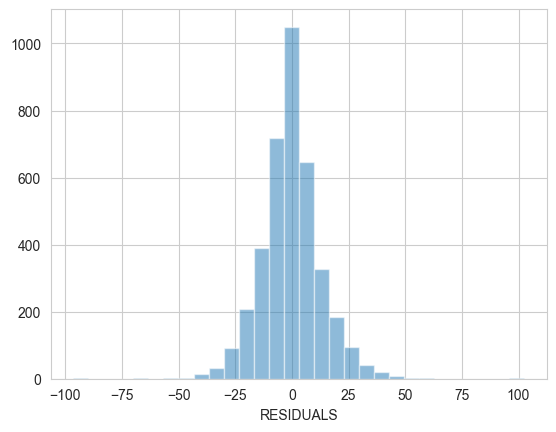


#############################
REGRESSION METRICS: 
mae = 9.613, r2 = 0.909
#############################


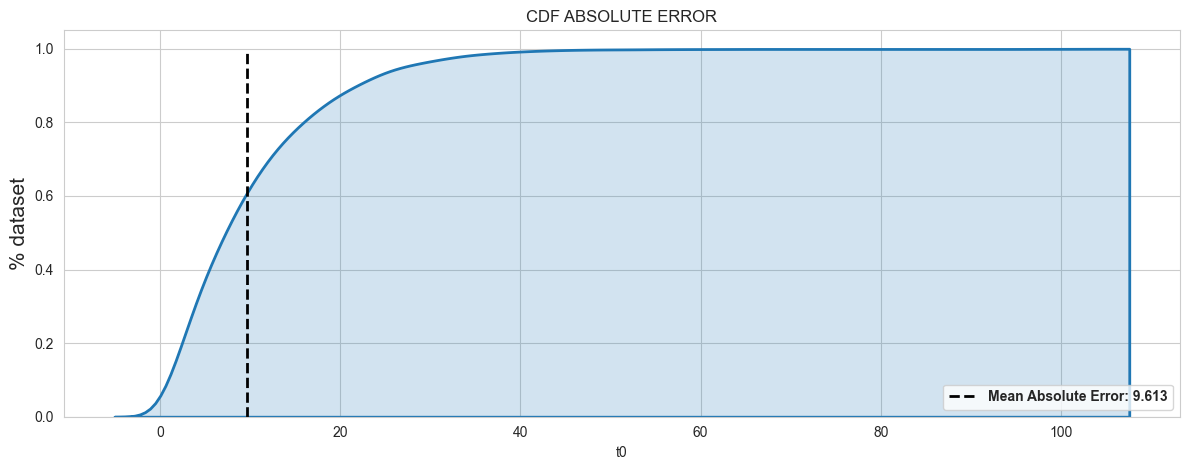

{'mae': 9.613, 'r2': 0.909}

In [13]:
ml_metrics = taxi_display_mlmodel_performance(y, y_pred)
ml_metrics

## FORECASTING:

In [14]:
past_30_days_demand = list(df_ml_tr.t0.values[-24*30:])

len(past_30_days_demand)

720

In [15]:
y_pred =  taxi_make_forecast(past_30_days_demand, trained_model, forecast_horizon = 24*30)
y_pred.shape

(720,)

In [16]:
y = df_ml_ts.t0[:24*30].values
y.shape

(720,)

### MODEL PERFORMANCE IN FORECASTING MODE:


#############################
REGRESSION METRICS: 
mae = 9.336, r2 = 0.914
#############################


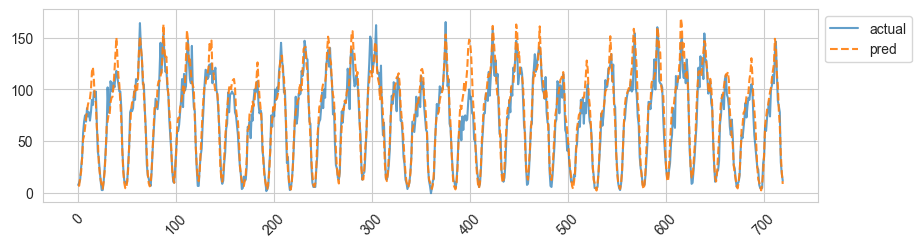

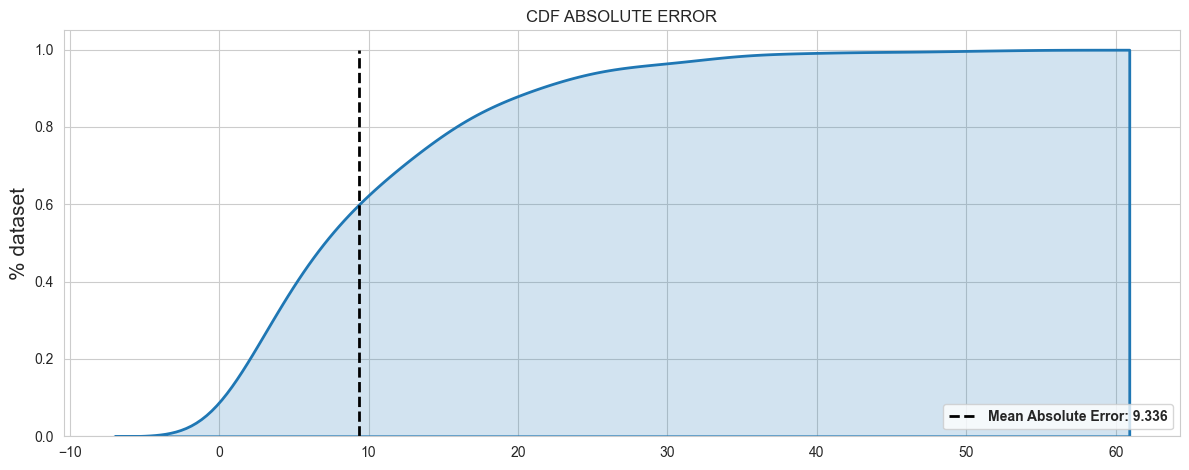

{'mae': 9.336, 'r2': 0.914}

In [17]:
forecaster_metrics = taxi_display_forecaster_performance(y, y_pred)
forecaster_metrics


In [20]:
forecaster_metrics

{'mae': 9.336, 'r2': 0.914}

### TRAIN MODEL ON WHOLE BACKFILLED DATA:

In [19]:
untrained_model = xgb.XGBRegressor(random_state = 8)
trained_model = taxi_train_ml_model(untrained_model, df_ml)
trained_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=8, ...)

### SAVE TRAINED MODEL TO MODEL REGISTRY:

In [23]:
from src.training_pipeline import taxi_save_model_to_registry

In [26]:
description = """
xgboost default model trained on backfilled data 2020-22

xgboost regressor trained of ml data got by using lagged features.

It predicts next value given previous 24*30 hrs (ie: 1 month) values.

It is used for time series forecasting by recursively feeding it its own previous predictions
that become part of the input data for the next step.
Used with the following function: "taxi_make_forecast(df_tr, model, forecasting_horizon)"
"""

model_name = "model_2020_22"
performance_dict = forecaster_metrics

In [27]:
taxi_save_model_to_registry(trained_model, model_name, description, df_ml_tr,
                                performance_dict)

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/571540
Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/455774 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/3383 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/226 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/571540/models/model_2020_22/1
